In [1]:
import os 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel
import itertools
import numpy as np
from copy import deepcopy
import itertools
import openpyxl

path_to_csvs = r"C:\Users\irs3th\keypoint-moseq\home_cage\results"  # change directory, data in syllable data.zip
os.chdir(path_to_csvs)

# Syllable frequency analysis

In [2]:
syllable_stats = pd.read_csv("syllable_stats_df.csv") #stats_df2
syllable_stats.head()

,group,id,syllable,heading_mean,heading_std,heading_min,heading_max,angular_velocity_mean,angular_velocity_std,angular_velocity_min,angular_velocity_max,velocity_px_s_mean,velocity_px_s_std,velocity_px_s_min,velocity_px_s_max,frequency,duration
0,LiCl,23,1,0.779509,2.020187,-3.141473,3.141435,-0.019048,12.137872,-188.264701,188.334696,46.452894,39.956007,0.046856,420.224734,0.084437,0.901804
1,LiCl,23,3,0.633897,2.008913,-3.140611,3.141426,0.007360,7.544143,-188.386901,188.394361,24.156338,14.626850,0.202722,167.511145,0.087086,0.949810
2,LiCl,23,4,0.038109,1.714099,-1.705007,2.966418,-4.826163,25.076716,-94.907551,67.816638,166.255258,135.391170,9.396631,466.788964,0.002980,0.133333
3,LiCl,23,5,-1.585357,0.253026,-1.941236,-1.154836,-0.929828,0.708453,-2.170858,0.393886,135.418804,72.093573,0.000000,319.797401,0.001656,0.520000
4,LiCl,23,6,-0.466495,1.931421,-2.026563,1.693766,-0.295888,0.832640,-1.179633,0.473910,128.717633,54.328756,95.527732,191.415041,0.000993,0.040000


## Frequency scatter plot

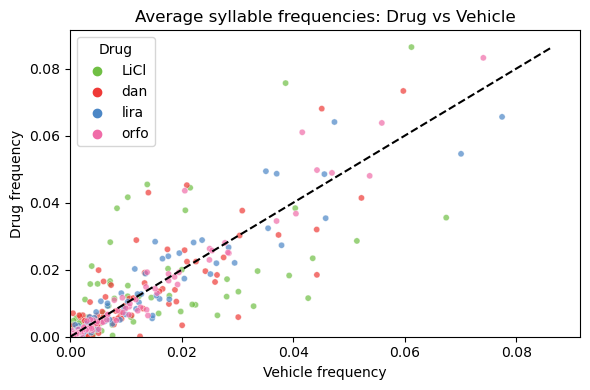

In [21]:
# drug to vehicle mapping
vehicle_map = {
    "LiCl": "saline_licl",
   "dan": "veh",
   "lira": "saline_lira",
    "orfo": "saline_orfo"
}

group_color_map = {
    "orfo": "#F06CA8",
    "dan": "#EF3A37",
   "lira": "#4C87C6",
    "LiCl": "#70BF44"
}

# keep only drugs and their vehicles
valid_groups = list(vehicle_map.keys()) + list(vehicle_map.values())
syllable_stats_plot = syllable_stats[syllable_stats["group"].isin(valid_groups)]

merged = []
for drug, vehicle in vehicle_map.items():
    # pivot drug group: fill missing syllables for any mouse with 0
    drug_pivot = (
        syllable_stats_plot[syllable_stats_plot["group"] == drug]
        .pivot_table(index="id", columns="syllable", values="frequency", fill_value=0)
    )
    drug_mean = drug_pivot.mean(axis=0).reset_index()
    drug_mean.columns = ["syllable", "freq_drug"]

    # pivot vehicle group: fill missing syllables for any mouse with 0
    veh_pivot = (
        syllable_stats_plot[syllable_stats_plot["group"] == vehicle]
        .pivot_table(index="id", columns="syllable", values="frequency", fill_value=0)
    )
    veh_mean = veh_pivot.mean(axis=0).reset_index()
    veh_mean.columns = ["syllable", "freq_vehicle"]

    # merge means on syllable
    merged_df = pd.merge(drug_mean, veh_mean, on="syllable", how="inner")
    merged_df["drug"] = drug
    merged.append(merged_df)

plot_df = pd.concat(merged, ignore_index=True)

# plot
plt.figure(figsize=(6, 4))

sns.scatterplot(
    data=plot_df,
    x="freq_vehicle", y="freq_drug",
    hue="drug", palette=group_color_map, alpha=0.7, s=20
)

# diagonal reference line
max_val = plot_df[["freq_vehicle", "freq_drug"]].max().max()
plt.plot([0, max_val], [0, max_val], color="black", linestyle="--")
plt.xlabel("Vehicle frequency")
plt.ylabel("Drug frequency")
plt.title("Average syllable frequencies: Drug vs Vehicle")
plt.legend(title="Drug")
plt.tight_layout()
plt.xlim(0, max_val + 0.005)
plt.ylim(0, max_val + 0.005)
#plt.savefig('dot_plot_freq.png')
plt.show()

## Paired t-test (syllable frequency)

In [158]:
# Filter to groups of interest first
groups = ['saline_orfo', 'orfo']
orfo_stats = syllable_stats[syllable_stats['group'].isin(groups)]

# Define all mouse IDs and all syllables 
all_ids = orfo_stats['id'].unique()
all_syllables = orfo_stats['syllable'].unique()

# Create full ID × syllable × group combinations
full_index = pd.DataFrame(list(itertools.product(all_ids, all_syllables, groups)),
                          columns=['id', 'syllable', 'group'])

# Merge actual frequency data
full_data = pd.merge(full_index, orfo_stats[['id','syllable','group','frequency']],
                     on=['id','syllable','group'], how='left')

# Fill missing frequencies with 0
full_data['frequency'] = full_data['frequency'].fillna(0)

paired_results = []
per_syllable_dfs = []

for syll in all_syllables:
    df_syll = full_data[full_data['syllable'] == syll].pivot(index='id', columns='group', values='frequency')
    # fill missing columns with 0
    for grp in groups:
        if grp not in df_syll.columns:
            df_syll[grp] = 0

    # paired t-test
    t_stat, p_val = ttest_rel(df_syll['saline_orfo'], df_syll['orfo'])
    saline_mean = df_syll['saline_orfo'].mean()
    orfo_mean = df_syll['orfo'].mean()
    df_val = len(df_syll) - 1

    # Only keep results with p < 0.05
    if p_val < 0.05:
        paired_results.append({
            'syllable': syll,
            't_stat': t_stat,
            'p_value': p_val,
            'df': df_val,
            'saline_orfo_mean': saline_mean,
            'orfo_mean': orfo_mean,
            'n': len(df_syll)
        })

        # optional: keep per-mouse details
        #temp_df = df_syll.copy()
        #temp_df['syllable'] = syll
        #temp_df['id'] = temp_df.index
        #per_syllable_dfs.append(temp_df.reset_index(drop=True))

# Convert to DataFrame
paired_df = pd.DataFrame(paired_results)

# Excel export
output_path = 'orfo_paired_ttest_results_significant.xlsx'
with pd.ExcelWriter(output_path, engine='openpyxl') as writer:
    paired_df.to_excel(writer, sheet_name='paired_significant', index=False)
    if per_syllable_dfs:
        per_mouse_detail = pd.concat(per_syllable_dfs, ignore_index=True)
        per_mouse_detail.to_excel(writer, sheet_name='per_mouse_detail', index=False)

print(f"\nPaired t-test results (p < 0.05) saved to: {output_path}")


Paired t-test results (p < 0.05) saved to: orfo_paired_ttest_results_significant.xlsx


## Different frequency plot

In [4]:
groups_of_interest = ['orfo', 'saline_orfo']
x_axis_order = [0, 2, 4, 5, 8, 10, 13, 17, 27, 35, 47, 54, 6, 7, 9, 14, 16, 18, 28, 31, 32, 37, 1,
                 11, 19, 20, 30, 33, 38, 15, 25, 26, 34, 41, 21, 22, 23, 44, 39, 48, 29, 43, 3, 12, 24]

# Filter data to groups of interest
plot_stats = syllable_stats[syllable_stats['group'].isin(groups_of_interest)].copy()

# All mouse IDs and syllables
all_ids = plot_stats['id'].unique()
all_syllables = x_axis_order

# Full combinations of id × syllable × group
full_index = pd.DataFrame(list(itertools.product(all_ids, all_syllables, groups_of_interest)),
                          columns=['id', 'syllable', 'group'])

# Merge actual data and fill missing frequencies with 0
full_data = pd.merge(full_index, plot_stats[['id','syllable','group','frequency']],
                     on=['id','syllable','group'], how='left')
full_data['frequency'] = full_data['frequency'].fillna(0)

# Compute mean and SEM per group × syllable
def compute_sem(x):
    n = len(x)
    return np.std(x, ddof=1)/np.sqrt(n) if n > 1 else 0

summary_df_full = (
    full_data
    .groupby(['group','syllable'])
    .agg(
        mean_frequency=('frequency', 'mean'),
        sem_frequency=('frequency', compute_sem)
    )
    .reset_index()
)

# Optional: sort for consistent plotting
summary_df_full = summary_df_full.sort_values(['syllable','group']).reset_index(drop=True)

print(summary_df_full.head())

         group  syllable  mean_frequency  sem_frequency
0         orfo         0        0.083226       0.013476
1  saline_orfo         0        0.074094       0.015205
2         orfo         1        0.048014       0.005959
3  saline_orfo         1        0.053709       0.008400
4         orfo         2        0.063807       0.008408


C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.3058823529411765, 0.3058823529411765, 0.3058823529411765)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,
C:\ProgramData\anaconda3\Lib\site-packages\seaborn\categorical.py:1728: UserWarning: You passed a edgecolor/edgecolors ((0.9411764705882353, 0.4235294117647059, 0.6588235294117647)) for an unfilled marker ('').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(x, y, label=hue_level,


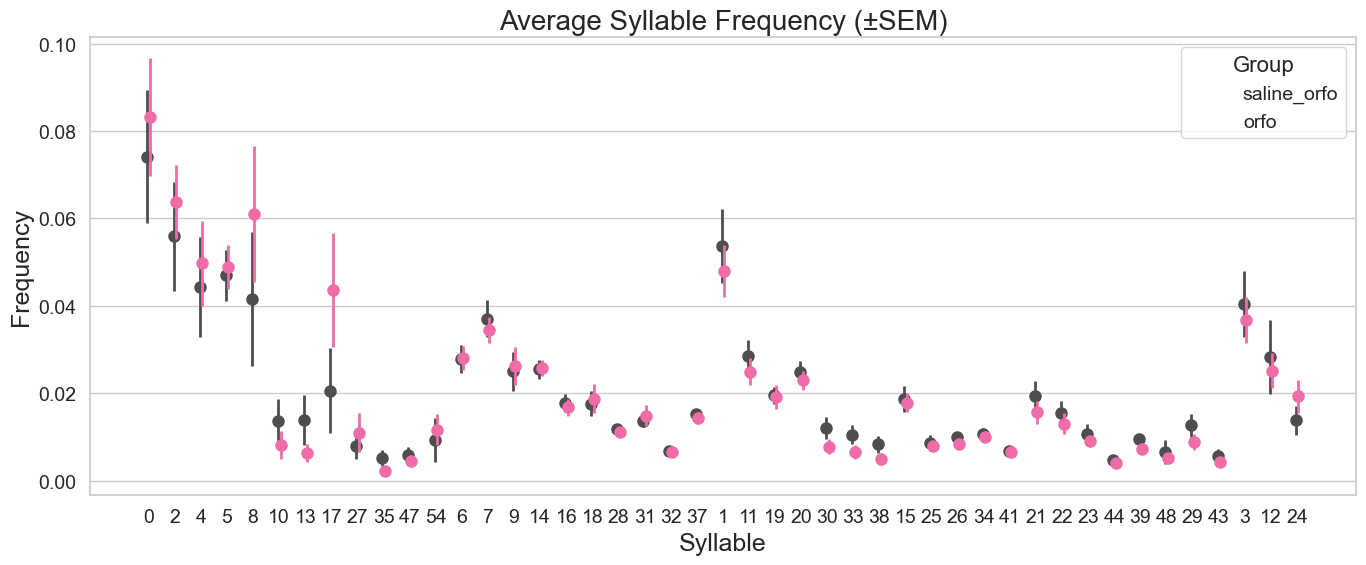

In [7]:
group_color_map = {
    'orfo': "#F06CA8",
    'saline_orfo': '#4E4E4E',
}

# Optional manual dodge offsets for groups 
group_offsets = {
    'saline_orfo': -0.05,
    'orfo': 0.05
}

plot_df = summary_df_full

sns.set(style="whitegrid", font_scale=1.5)
plt.figure(figsize=(14, 6))

hue_order = ['saline_orfo','orfo']

ax = sns.pointplot(
    data=plot_df,
    x='syllable',
    y='mean_frequency',
    hue='group',
    dodge=True,
    join=False,
    palette=group_color_map,
    errorbar=None,
    markers='',   
    scale=1.2,
    order=x_axis_order,
    hue_order=hue_order
)

for i, syll in enumerate(x_axis_order):
    for grp in hue_order:
        row = plot_df[(plot_df['syllable'] == syll) & (plot_df['group'] == grp)]
        if row.empty or pd.isna(row['mean_frequency'].values[0]):
            continue

        x = i + group_offsets[grp]
        y = row['mean_frequency'].values[0]
        sem_val = row['sem_frequency'].values[0]
        color = group_color_map[grp]

        plt.errorbar(
            x=x,
            y=y,
            yerr=sem_val,
            fmt='o',
            ecolor=color,
            markersize=8,
            mec=color,
            mfc=color,
            linewidth=2,
            zorder=3 if grp=='orfo' else 2
        )

plt.xlabel('Syllable', fontsize=18)
plt.ylabel('Frequency', fontsize=18)
plt.title('Average Syllable Frequency (±SEM)', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(title='Group', fontsize=14, title_fontsize=16)
plt.tight_layout()
plt.show()

# Transition analysis (code modified from https://keypoint-moseq.readthedocs.io/en/latest/index.html)

In [121]:
moseq_df = pd.read_csv("syllable_df.csv") # 'raw' results from Keypoint-MoSeq model (+ id and group column)
moseq_df.head()

,Unnamed: 0,name,centroid_x,centroid_y,heading,angular_velocity,velocity_px_s,syllable,frame_index,group,onset,id
0,0,LiCl_arena1_23_re,250.626357,249.345477,-1.546838,0.000000,0.000000,5,0,LiCl,True,23
1,1,LiCl_arena1_23_re,251.069955,248.964050,-1.546114,0.005708,17.551053,5,1,LiCl,False,23
2,2,LiCl_arena1_23_re,252.397172,248.069515,-1.546126,0.014617,48.015911,5,2,LiCl,False,23
3,3,LiCl_arena1_23_re,251.567454,247.550788,-1.546838,0.029765,29.355738,5,3,LiCl,False,23
4,4,LiCl_arena1_23_re,250.065323,247.081476,-1.546838,0.053616,47.212141,5,4,LiCl,False,23


## For plotting: subset to frequent syllables of interest then normalize (bigram) to visualize only selected syllables clearly.

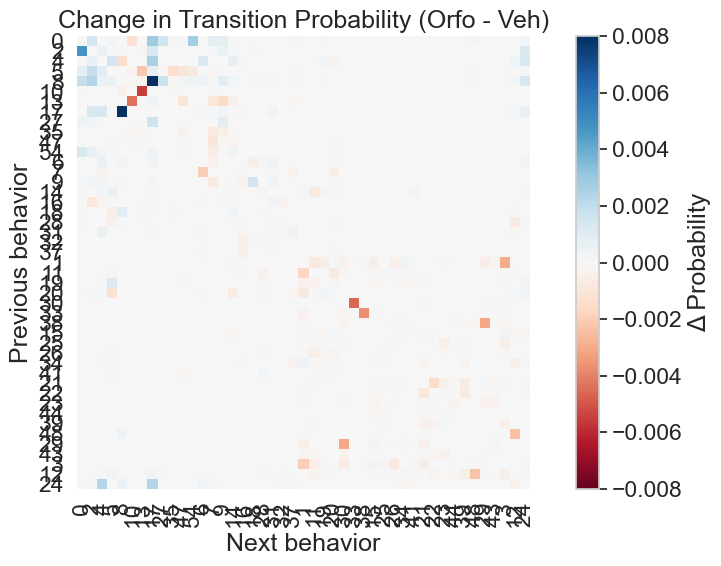

In [149]:
# Helper functions
def sliding_window(n, seq):
    it = iter(seq)
    window = []
    for _ in range(n):
        window.append(next(it))
    yield tuple(window)
    for elem in it:
        window = window[1:] + [elem]
        yield tuple(window)

def get_transitions(label_sequence):
    arr = deepcopy(label_sequence)
    locs = np.where(arr[1:] != arr[:-1])[0] + 1
    transitions = arr[locs]
    return transitions, locs

def n_gram_transition_matrix(labels, n=2, max_label=99):
    trans_mat = np.zeros((max_label,) * n, dtype="float")
    for loc in sliding_window(n, labels):
        if any(l >= max_label for l in loc):
            continue
        trans_mat[loc] += 1
    return trans_mat

def normalize_transition_matrix(init_matrix, normalize):
    if normalize is None or normalize not in ("bigram", "rows", "columns"):
        return init_matrix
    if normalize == "bigram":
        init_matrix = init_matrix / init_matrix.sum()
    elif normalize == "rows":
        init_matrix = init_matrix / init_matrix.sum(axis=1, keepdims=True)
    elif normalize == "columns":
        init_matrix = init_matrix / init_matrix.sum(axis=0, keepdims=True)
    return np.nan_to_num(init_matrix)

def get_transition_matrix(labels, max_syllable=100, normalize="bigram", smoothing=0.0):
    transitions = get_transitions(labels)[0]
    trans_mat = n_gram_transition_matrix(transitions, n=2, max_label=max_syllable) + smoothing
    return normalize_transition_matrix(trans_mat, normalize)

# Per-animal transition matrices 
def get_individual_trans_mats(labels, label_group, label_id, max_syllable, normalize="bigram"):
    mats = []
    meta = []
    for lbl, grp, id_ in zip(labels, label_group, label_id):
        mat = get_transition_matrix(lbl, max_syllable=max_syllable, normalize=normalize)
        mats.append(mat)
        meta.append({"id": id_, "group": grp})
    return np.array(mats), pd.DataFrame(meta)

# Difference + stats
def compute_group_differences(mats, meta, group1, group2):
    df = pd.concat(
        [meta.reset_index(drop=True), 
         pd.DataFrame(mats.reshape(mats.shape[0], -1))],
        axis=1
    )

    common_ids = sorted(set(df[df['group'] == group1]['id']) & set(df[df['group'] == group2]['id']))

    diffs = []
    for id_ in common_ids:
        vec1 = df[(df['id'] == id_) & (df['group'] == group1)].iloc[:, 2:].values[0]
        vec2 = df[(df['id'] == id_) & (df['group'] == group2)].iloc[:, 2:].values[0]
        diffs.append(vec2 - vec1)

    diffs = np.array(diffs)
    mean_diff = diffs.mean(axis=0)

    t_stat, p_vals = ttest_rel(diffs, np.zeros_like(diffs), axis=0)
    p_vals = p_vals.reshape(mats.shape[1], mats.shape[2])
    mean_diff = mean_diff.reshape(mats.shape[1], mats.shape[2])

    return mean_diff, p_vals


# Plot heatmap
def plot_diff_heatmap(mean_diff, p_vals, syll_names, alpha=0.05):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    im = ax.imshow(mean_diff, cmap="RdBu", vmin=-0.008, vmax=0.008)

    ax.set_xticks(np.arange(len(syll_names)))
    ax.set_yticks(np.arange(len(syll_names)))
    ax.set_xticklabels(syll_names, rotation=90)
    ax.set_yticklabels(syll_names)
    ax.set_xlabel("Next behavior")
    ax.set_ylabel("Previous behavior")
    ax.set_title("Change in Transition Probability (Orfo - Veh)")
    
    fig.colorbar(im, ax=ax, label="Δ Probability")
    # Remove grid lines
    ax.grid(False)                 
    for spine in ax.spines.values():  
        spine.set_visible(False)
        
    plt.tight_layout()
    #plt.savefig('orfo_delta_transition.eps', format='eps', dpi=300)
    plt.show()

# Run pipeline
syllables_to_keep = [
    0, 2, 4, 5, 8, 10, 13, 17, 27, 35, 47, 54,
    6, 7, 9, 14, 16, 18, 28, 31, 32, 37,
    1, 11, 19, 20, 30, 33, 38,
    15, 25, 26, 34, 41, 
    21, 22, 23, 44, 39, 48, 29, 43,
    3, 12, 24
]

moseq_df['syllable'] = moseq_df['syllable'].astype(int)
video_names = moseq_df['name'].unique()

labels = []
label_group = []
label_id = []

for vid in video_names:
    vid_df = moseq_df[moseq_df['name'] == vid].sort_values('frame_index')
    labels.append(vid_df['syllable'].to_numpy())
    label_group.append(vid_df['group'].iloc[0])
    label_id.append(vid_df['id'].iloc[0])

groups = sorted(moseq_df['group'].unique())
syll_include = np.array(syllables_to_keep)
syll_names = [str(s) for s in syll_include]

max_syll = max(syll_include) + 1
mats, meta = get_individual_trans_mats(labels, label_group, label_id, max_syll, normalize="bigram")


mean_diff, p_vals = compute_group_differences(mats, meta,
                                             group1="saline_orfo",
                                             group2="orfo")

# Slice for plotting only (keeps your exact plot)
mean_diff_plot = mean_diff[np.ix_(syll_include, syll_include)]
p_vals_plot = p_vals[np.ix_(syll_include, syll_include)]

plot_diff_heatmap(mean_diff_plot, p_vals_plot, syll_names)

## For stats: normalize on the full transition matrix first, then subset, so probabilities reflect the animal's full behavioral distribution for group comparisons.

In [155]:
# Bigram normalization for full dataset => stats 
def get_fullnorm_matrix(labels, max_label, normalize="bigram", smoothing=0.0):
    transitions = get_transitions(labels)[0]
    # full transition matrix (counts)
    full_mat = n_gram_transition_matrix(transitions, n=2, max_label=max_label)
    # smoothing
    full_mat = full_mat + smoothing
    # normalize across the full matrix
    full_mat = normalize_transition_matrix(full_mat, normalize)
    return full_mat

def get_individual_mats_fullnorm(labels, label_group, label_id, max_label, normalize="bigram"):
    mats = []
    meta = []

    for lbl, grp, id_ in zip(labels, label_group, label_id):
        mat = get_fullnorm_matrix(lbl, max_label, normalize)
        mats.append(mat)
        meta.append({"id": id_, "group": grp})

    return np.array(mats), pd.DataFrame(meta)

def compute_group_differences_fullnorm(mats, meta, group1, group2):
    df = pd.concat([
        meta.reset_index(drop=True),
        pd.DataFrame(mats.reshape(mats.shape[0], -1))
    ], axis=1)

    # paired IDs
    common_ids = sorted(
        set(df[df['group'] == group1]['id']) &
        set(df[df['group'] == group2]['id'])
    )

    diffs = []
    for id_ in common_ids:
        vec1 = df[(df['id'] == id_) & (df['group'] == group1)].iloc[:, 2:].values[0]
        vec2 = df[(df['id'] == id_) & (df['group'] == group2)].iloc[:, 2:].values[0]
        diffs.append(vec2 - vec1)

    diffs = np.array(diffs)
    mean_diff = diffs.mean(axis=0)

    # paired t test
    t_stat, p_vals = ttest_rel(diffs, np.zeros_like(diffs), axis=0)

    K = mats.shape[1]
    return (
        mean_diff.reshape(K, K),
        p_vals.reshape(K, K)
    )

def save_full_matrix_stats_to_excel(mean_diff, p_vals, output_file="transition_stats_full.xlsx"):
    K = mean_diff.shape[0]
    results = []

    for i in range(K):
        for j in range(K):
            results.append({
                "from_syllable": i,
                "to_syllable": j,
                "mean_diff": mean_diff[i, j],
                "p_value": p_vals[i, j]
            })

    df_results = pd.DataFrame(results)

    # Filter by p < 0.05
    df_results = df_results[df_results["p_value"] < 0.05]

    # Sort by 'from' syllable
    df_results = df_results.sort_values(["from_syllable", "to_syllable"])

    # Save to Excel
    df_results.to_excel(output_file, index=False)
    print(f"Saved filtered transition statistics (p < 0.05) to '{output_file}'")
    return df_results

max_label = moseq_df["syllable"].max() + 1

# build full-normalized matrices
mats_full, meta_full = get_individual_mats_fullnorm(
    labels,
    label_group,
    label_id,
    max_label,
    normalize="bigram"
)

# compute stats
mean_diff_full, p_vals_full = compute_group_differences_fullnorm(
    mats_full,
    meta_full,
    group1="saline_orfo",
    group2="orfo"
)

# save as Excel
df_stats_full = save_full_matrix_stats_to_excel(
    mean_diff_full,
    p_vals_full,
    output_file="transition_stats_full.xlsx"
)

Saved filtered transition statistics (p < 0.05) to 'transition_stats_full.xlsx'
